In [1]:
from bike_class import BikeShareDataLoader
import requests
import zipfile
import io
import pandas as pd
import chardet

In [2]:


'''
URL to the metadata from the City of Toronto's Open Data portal
 This URL points to the JSON metadata for the Bike Share Toronto ridership data
 '''
url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show?id=bike-share-toronto-ridership-data"
metadata = BikeShareDataLoader(url)



In [3]:
# Load all the dataframes for each year
#df_2017 = metadata.create_df(2017)
# df_2018 = metadata.create_df(2018)
# df_2019 = metadata.create_df(2019)
# df_2020 = metadata.create_df(2020)
# df_2021 = metadata.create_df(2021)
# df_2022 = metadata.create_df(2022)
# df_2023 = metadata.create_df(2023)
df_2024 = metadata.create_df(2024)

In [4]:
df_2024.head()

,Trip Id,Trip Duration,Start Station Id,Start Time,Start Station Name,End Station Id,End Time,End Station Name,Bike Id,User Type,Model
0,26682740,528,7041,01/01/2024 00:00,Edward St / Yonge St,7130.0,01/01/2024 00:08,Davenport Rd / Bedford Rd,7855,Casual Member,NaN
1,26682742,1924,7245,01/01/2024 00:02,Tecumseth St / Queen St W - SMART,7259.0,01/01/2024 00:34,Lower Spadina Ave / Lake Shore Blvd,2453,Casual Member,NaN
2,26682743,2741,7052,01/01/2024 00:03,Wellington St W / Bay St,7366.0,01/01/2024 00:49,Fort York Blvd / Bathurst St SMART,7332,Casual Member,NaN
3,26682744,353,7041,01/01/2024 00:03,Edward St / Yonge St,7418.0,01/01/2024 00:09,College Park - Yonge St Entrance,782,Casual Member,NaN
4,26682746,2118,7721,01/01/2024 00:04,NaN,7721.0,01/01/2024 00:40,NaN,1008,Casual Member,NaN


In [5]:
import re

def clean_col_names(df):
    """
    Standardize column names: lowercase, strip spaces, replace all whitespace with a single underscore,
    and remove duplicate underscores.
    """
    def fix_col(col):
        col = col.strip().lower()
        col = re.sub(r'\s+', '_', col)         # Replace all whitespace with underscore
        col = re.sub(r'_+', '_', col)          # Replace multiple underscores with one
        return col
    df.columns = [fix_col(col) for col in df.columns]
    return df

In [6]:
df = df_2024
clean_col_names(df)
df.columns

Index(['trip_id', 'trip_duration', 'start_station_id', 'start_time',
       'start_station_name', 'end_station_id', 'end_time', 'end_station_name',
       'bike_id', 'user_type', 'model'],
      dtype='object')

In [7]:
# Check for duplicate records based on 'trip_id'
duplicate_count = df.duplicated(subset=['trip_id']).sum()
print(f"Number of duplicate records based on trip_id: {duplicate_count}")

# Optionally, display the duplicate rows
if duplicate_count > 0:
    duplicates = df[df.duplicated(subset=['trip_id'], keep=False)]
    print(duplicates.head())

Number of duplicate records based on trip_id: 0


In [8]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5342388 entries, 0 to 5342387
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   trip_id             5342388 non-null  int64  
 1   trip_duration       5342388 non-null  int64  
 2   start_station_id    5342388 non-null  int64  
 3   start_time          5342388 non-null  object 
 4   start_station_name  5229427 non-null  object 
 5   end_station_id      5342293 non-null  float64
 6   end_time            5342388 non-null  object 
 7   end_station_name    5227546 non-null  object 
 8   bike_id             5342388 non-null  int64  
 9   user_type           5342388 non-null  object 
 10  model               5127226 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 448.4+ MB


In [9]:
(df.isnull().sum() / len(df)).sort_values(ascending=False)

model                 0.040274
end_station_name      0.021496
start_station_name    0.021144
end_station_id        0.000018
start_station_id      0.000000
trip_id               0.000000
trip_duration         0.000000
end_time              0.000000
start_time            0.000000
bike_id               0.000000
user_type             0.000000
dtype: float64

In [10]:
bikeshare_df = df.dropna()

In [11]:
# Display count of unique values for each column in bikeshare_df
for col in bikeshare_df.columns:
    print(f"Column: {col}")
    print(f"Unique count: {bikeshare_df[col].nunique()}")
    print("-" * 40)

Column: trip_id
Unique count: 4963572
----------------------------------------
Column: trip_duration
Unique count: 18543
----------------------------------------
Column: start_station_id
Unique count: 808
----------------------------------------
Column: start_time
Unique count: 321809
----------------------------------------
Column: start_station_name
Unique count: 905
----------------------------------------
Column: end_station_id
Unique count: 809
----------------------------------------
Column: end_time
Unique count: 322384
----------------------------------------
Column: end_station_name
Unique count: 906
----------------------------------------
Column: bike_id
Unique count: 8012
----------------------------------------
Column: user_type
Unique count: 2
----------------------------------------
Column: model
Unique count: 3
----------------------------------------


In [12]:
# There should only be two user types: Member and Casual
# Display unique values in the 'user_type' column
print("Unique user types:", bikeshare_df['user_type'].unique())

bikeshare_df['user_type'] = bikeshare_df['user_type'].replace({'Annual Member': 'Member', 'Casual Member': 'Casual'})
print("User types after standardization:", bikeshare_df['user_type'].unique())

Unique user types: ['Casual Member' 'Annual Member']
User types after standardization: ['Casual' 'Member']


/var/folders/6w/ztwdckfs2_1b1bkgxgn768jh0000gn/T/ipykernel_19269/2811367001.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikeshare_df['user_type'] = bikeshare_df['user_type'].replace({'Annual Member': 'Member', 'Casual Member': 'Casual'})


In [13]:
bikeshare_df.isnull().sum()

trip_id               0
trip_duration         0
start_station_id      0
start_time            0
start_station_name    0
end_station_id        0
end_time              0
end_station_name      0
bike_id               0
user_type             0
model                 0
dtype: int64

In [14]:
bikeshare_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4963572 entries, 204870 to 5342387
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   trip_id             int64  
 1   trip_duration       int64  
 2   start_station_id    int64  
 3   start_time          object 
 4   start_station_name  object 
 5   end_station_id      float64
 6   end_time            object 
 7   end_station_name    object 
 8   bike_id             int64  
 9   user_type           object 
 10  model               object 
dtypes: float64(1), int64(4), object(6)
memory usage: 454.4+ MB


## Feature Engineering

In [15]:
# Make copy of the cleaned dataframe for potential further processing without time-based features
og_bikeshare_df = bikeshare_df.copy()

In [16]:

bikeshare_df['starttime'] = pd.to_datetime(bikeshare_df['start_time'], errors='coerce')
bikeshare_df['endtime'] = pd.to_datetime(bikeshare_df['end_time'], errors='coerce')
bikeshare_df['start_station_id'] = bikeshare_df['start_station_id'].astype(int)
bikeshare_df['end_station_id'] = bikeshare_df['end_station_id'].astype(int)
bikeshare_df['start_station_name'] = bikeshare_df['start_station_name'].astype(str)
bikeshare_df['end_station_name'] = bikeshare_df['end_station_name'].astype(str)
bikeshare_df['user_type'] = bikeshare_df['user_type'].astype(str)

/var/folders/6w/ztwdckfs2_1b1bkgxgn768jh0000gn/T/ipykernel_19269/483839253.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikeshare_df['starttime'] = pd.to_datetime(bikeshare_df['start_time'], errors='coerce')
/var/folders/6w/ztwdckfs2_1b1bkgxgn768jh0000gn/T/ipykernel_19269/483839253.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikeshare_df['endtime'] = pd.to_datetime(bikeshare_df['end_time'], errors='coerce')
/var/folders/6w/ztwdckfs2_1b1bkgxgn768jh0000gn/T/ipykernel_19269/483839253.py:3: Setti

In [17]:
bikeshare_df.isnull().sum()

trip_id               0
trip_duration         0
start_station_id      0
start_time            0
start_station_name    0
end_station_id        0
end_time              0
end_station_name      0
bike_id               0
user_type             0
model                 0
starttime             0
endtime               0
dtype: int64

In [18]:
# Extract features for ML
bikeshare_df['start_hour'] = bikeshare_df['starttime'].dt.hour
bikeshare_df['start_dayofweek'] = bikeshare_df['starttime'].dt.dayofweek  # Monday=0, Sunday=6
bikeshare_df['start_month'] = bikeshare_df['starttime'].dt.month
bikeshare_df['is_weekend'] = bikeshare_df['start_dayofweek'].isin([5, 6]).astype(int)

/var/folders/6w/ztwdckfs2_1b1bkgxgn768jh0000gn/T/ipykernel_19269/1938664584.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikeshare_df['start_hour'] = bikeshare_df['starttime'].dt.hour
/var/folders/6w/ztwdckfs2_1b1bkgxgn768jh0000gn/T/ipykernel_19269/1938664584.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikeshare_df['start_dayofweek'] = bikeshare_df['starttime'].dt.dayofweek  # Monday=0, Sunday=6
/var/folders/6w/ztwdckfs2_1b1bkgxgn768jh0000gn/T/ipykernel_19269/1938664584.py:4: SettingWithCopyW

In [19]:
# Dictionary: start station id to name
start_station_id_to_name = dict(zip(bikeshare_df['start_station_id'], bikeshare_df['start_station_name']))

# Dictionary: end station id to name
end_station_id_to_name = dict(zip(bikeshare_df['end_station_id'], bikeshare_df['end_station_name']))

# Dictionary: day of week mapping (0=Monday, 6=Sunday)
day_of_week_map = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

In [20]:
# Combine start_id_to_name and end_id_to_name into one dictionary with unique values
station_to_name = {**start_station_id_to_name, **end_station_id_to_name}


In [21]:

# Checking the final structure of the dictionary
print(f"Total stations: {len(station_to_name)}")
print("Sample items:", list(station_to_name.items())[:10])
print("Key types:", set(type(k) for k in station_to_name.keys()))

Total stations: 809
Sample items: [(7458, 'Church St / Lombard St'), (7285, 'Spadina Ave / Harbord St - SMART'), (7531, '541 Huron St - SMART'), (7027, 'Beverley St / Dundas St W'), (7469, 'York St / Wellington St W '), (7033, 'Union Station'), (7164, 'Gould St / Yonge St (TMU)'), (7414, 'Keele St / Annette St'), (7693, 'Mutual St / Shuter St (Arena Gardens)'), (7044, 'Church St / Alexander St')]
Key types: {<class 'int'>}


In [22]:
bikeshare_df.head()

,trip_id,trip_duration,start_station_id,start_time,start_station_name,end_station_id,end_time,end_station_name,bike_id,user_type,model,starttime,endtime,start_hour,start_dayofweek,start_month,is_weekend
204870,26916635,897,7458,02/01/2024 00:00,Church St / Lombard St,7256,02/01/2024 00:15,Vanauley St / Queen St W - SMART,2325,Casual,ICONIC,2024-02-01 00:00:00,2024-02-01 00:15:00,0,3,2,0
204871,26916636,267,7285,02/01/2024 00:02,Spadina Ave / Harbord St - SMART,7023,02/01/2024 00:06,College St / Borden St,623,Member,ICONIC,2024-02-01 00:02:00,2024-02-01 00:06:00,0,3,2,0
204872,26916637,158,7531,02/01/2024 00:02,541 Huron St - SMART,7058,02/01/2024 00:05,Huron/ Harbord St,7284,Member,ICONIC,2024-02-01 00:02:00,2024-02-01 00:05:00,0,3,2,0
204873,26916638,357,7027,02/01/2024 00:02,Beverley St / Dundas St W,7206,02/01/2024 00:08,Claremont St / Dundas St W,6595,Casual,ICONIC,2024-02-01 00:02:00,2024-02-01 00:08:00,0,3,2,0
204874,26916639,195,7469,02/01/2024 00:02,Wellington St W / York St,7417,02/01/2024 00:05,King St W / Jordan St,357,Casual,ICONIC,2024-02-01 00:02:00,2024-02-01 00:05:00,0,3,2,0


In [23]:
# Check if there are inconsistent names for the same station ID
start_station_check = bikeshare_df.groupby('start_station_id')['start_station_name'].nunique()
inconsistent_stations = start_station_check[start_station_check > 1]
if len(inconsistent_stations) > 0:
    print(f"\nFound {len(inconsistent_stations)} station IDs with multiple names")
    print(inconsistent_stations.head())
    
    # Example of inconsistent names for the first problematic ID
    if len(inconsistent_stations) > 0:
        example_id = inconsistent_stations.index[0]
        example_names = bikeshare_df[bikeshare_df['start_station_id'] == example_id]['start_station_name'].unique()
        print(f"\nExample - ID {example_id} has these names: {example_names}")


Found 98 station IDs with multiple names
start_station_id
7008    2
7017    2
7019    2
7027    2
7049    2
Name: start_station_name, dtype: int64

Example - ID 7008 has these names: ["Wellesley St / Queen's Park Cres" "Wellesley St W / Queen's Park Cres"]


In [24]:
# Assumption: Station names are unique for each id, but there might be inconsistencies since we are now taking the most common name per id.

# Fix station_id to name mapping by choosing the most common name for each station_id

most_common_start_names = bikeshare_df.groupby('start_station_id')['start_station_name'] \
    .agg(lambda x: x.value_counts().idxmax())
most_common_end_names = bikeshare_df.groupby('end_station_id')['end_station_name'] \
    .agg(lambda x: x.value_counts().idxmax())

# Create new dictionaries with the most common name for each station id
start_station_id_to_name_fixed = most_common_start_names.to_dict()
end_station_id_to_name_fixed = most_common_end_names.to_dict()

# Combine into one dictionary (start and end)
station_to_name_final = {**start_station_id_to_name_fixed, **end_station_id_to_name_fixed}

## Data Visualization

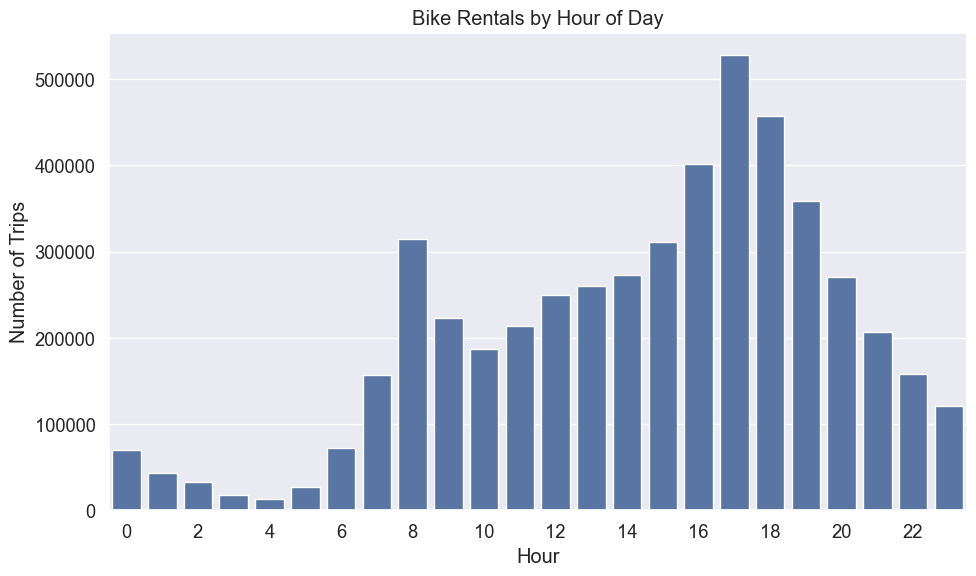

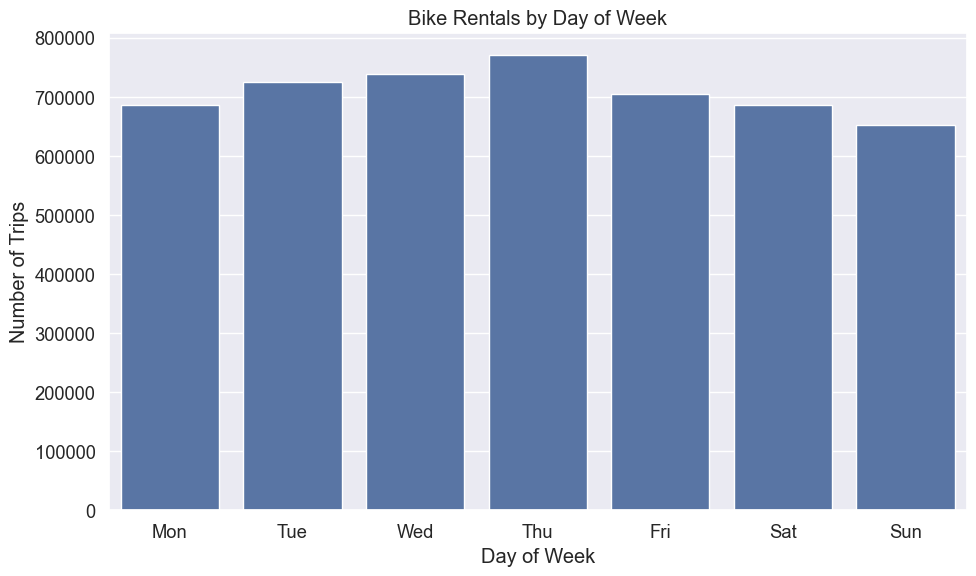

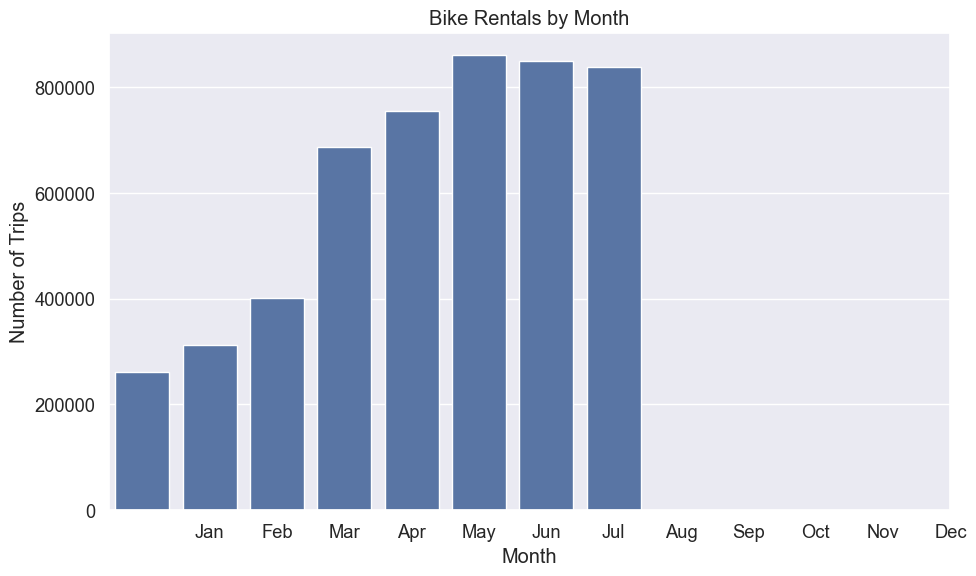

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up style
plt.style.use('ggplot')
sns.set(font_scale=1.2)

# 1. Hourly usage patterns
hourly_counts = bikeshare_df.groupby('start_hour').size()
plt.figure(figsize=(10, 6))
sns.barplot(x=hourly_counts.index, y=hourly_counts.values)
plt.title('Bike Rentals by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Trips')
plt.xticks(range(0, 24, 2))
plt.tight_layout()
plt.show()

# 2. Daily patterns
daily_counts = bikeshare_df.groupby('start_dayofweek').size()
plt.figure(figsize=(10, 6))
sns.barplot(x=daily_counts.index, y=daily_counts.values)
plt.title('Bike Rentals by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Trips')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.tight_layout()
plt.show()

# 3. Monthly trends
monthly_counts = bikeshare_df.groupby('start_month').size()
plt.figure(figsize=(10, 6))
sns.barplot(x=monthly_counts.index, y=monthly_counts.values)
plt.title('Bike Rentals by Month')
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

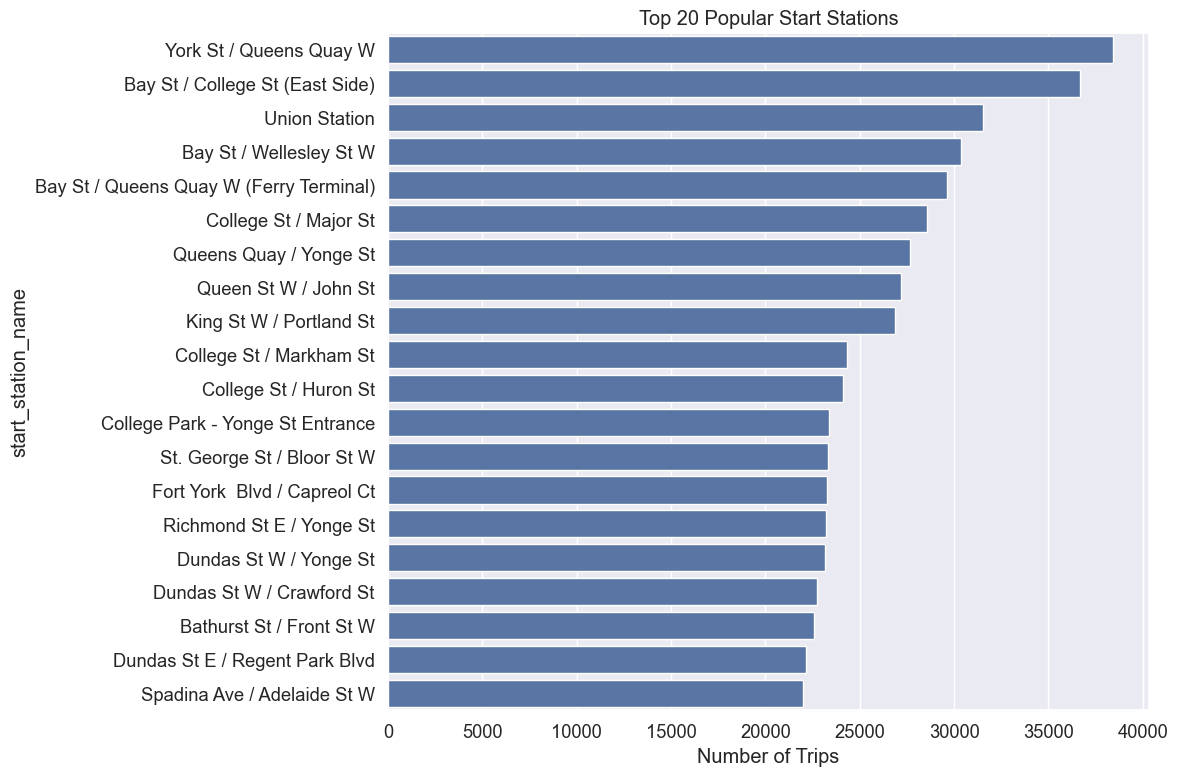

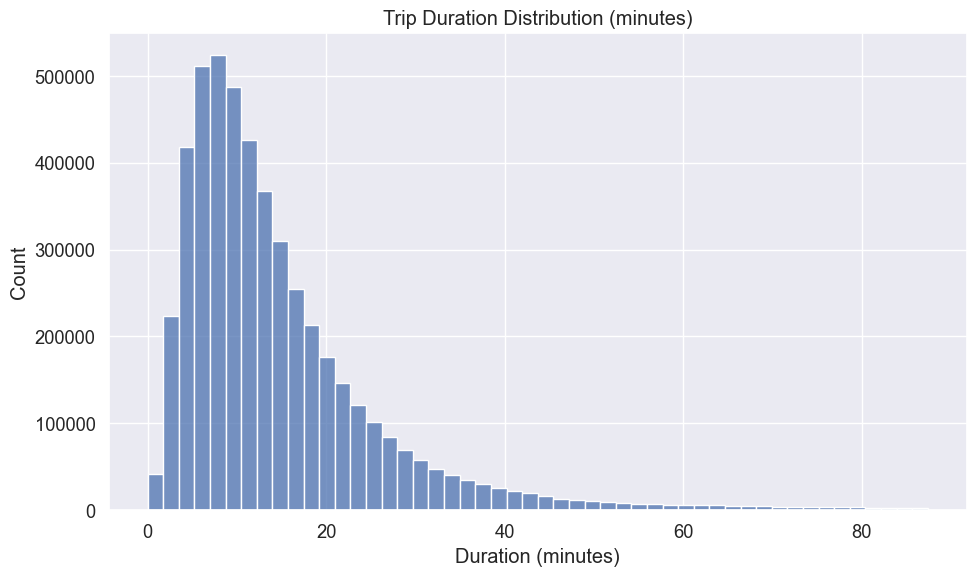

In [26]:
# 4. Top 20 most popular start stations
top_start = bikeshare_df['start_station_name'].value_counts().head(20)
plt.figure(figsize=(12, 8))
sns.barplot(x=top_start.values, y=top_start.index)
plt.title('Top 20 Popular Start Stations')
plt.xlabel('Number of Trips')
plt.tight_layout()
plt.show()

# 5. Trip duration distribution
plt.figure(figsize=(10, 6))
# Cap at 99th percentile to avoid outliers stretching the plot
duration_cap = bikeshare_df['trip_duration'].quantile(0.99)
sns.histplot(bikeshare_df[bikeshare_df['trip_duration'] < duration_cap]['trip_duration'] / 60, bins=50)
plt.title('Trip Duration Distribution (minutes)')
plt.xlabel('Duration (minutes)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

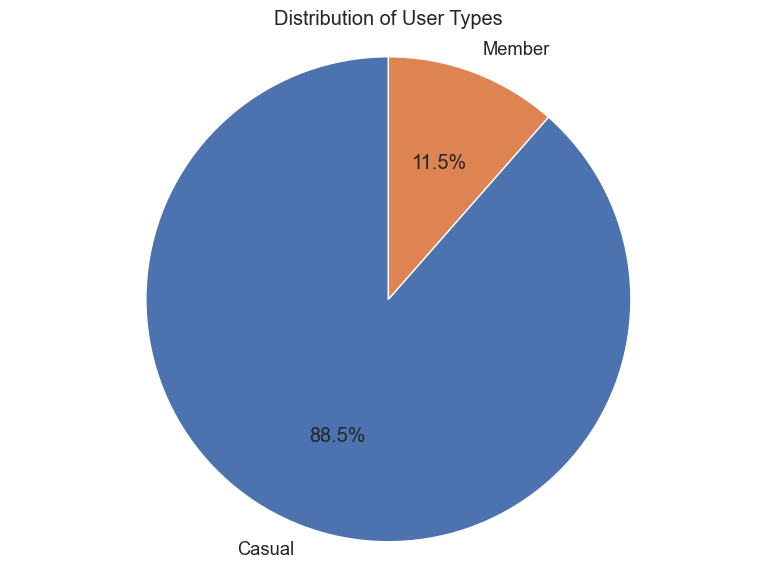

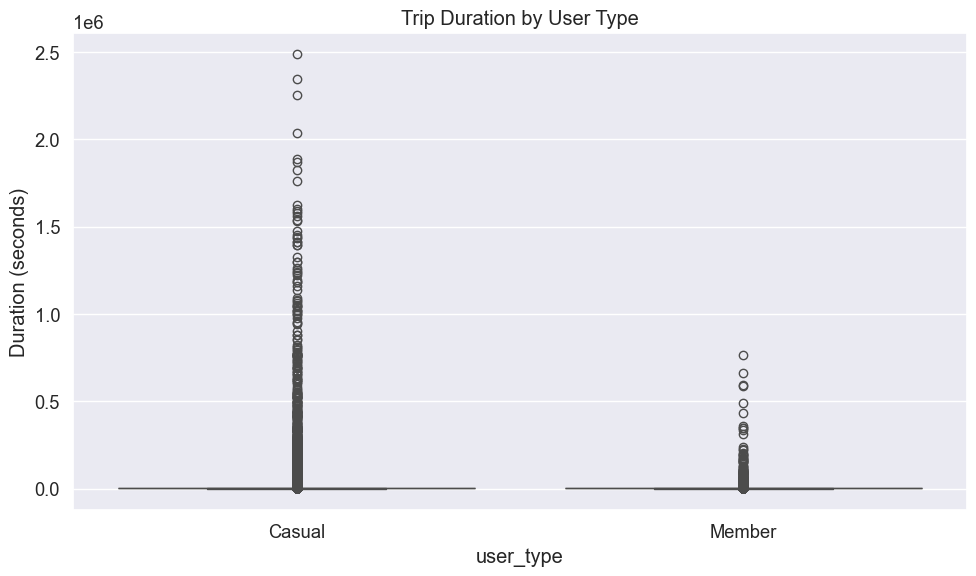

In [27]:
# 6. User type distribution
plt.figure(figsize=(8, 6))
user_counts = bikeshare_df['user_type'].value_counts()
plt.pie(user_counts, labels=user_counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of User Types')
plt.tight_layout()
plt.show()

# 7. Trip duration by user type
plt.figure(figsize=(10, 6))
sns.boxplot(x='user_type', y='trip_duration', data=bikeshare_df)
plt.title('Trip Duration by User Type')
plt.ylabel('Duration (seconds)')
plt.tight_layout()
plt.show()

# Binary Classification Predicting User Type Member vs. Casual

In [28]:
# Check for outliers in trip_duration (in seconds)
# over 180 minutes is not typical for bike trips. Could be a stolen bike or data error
outlier_threshold = 180 * 60  # 5400 seconds

# Find outliers
outliers = bikeshare_df[bikeshare_df['trip_duration'] > outlier_threshold]
print(f"Number of trips longer than 3 hours {len(outliers)}")
print(outliers[['trip_id', 'trip_duration', 'user_type']].head())

Number of trips longer than 3 hours 10496
         trip_id  trip_duration user_type
205626  26917525          24813    Casual
206334  26918262          18754    Casual
207578  26919704          21583    Casual
207733  26919884          26859    Casual
208060  26920284          11725    Casual


In [29]:
# Drop the outlier rows from bikeshare_df using their index
bikeshare_df = bikeshare_df.drop(outliers.index)

In [30]:

# import packages for machine learning
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score


In [31]:
df = bikeshare_df.copy()

In [32]:

# Drop columns not necessary for model training

X = df.drop(columns=['trip_id', 'start_time', 'end_time', 'starttime','endtime', 'user_type','start_station_name', 'end_station_name'])
y = df['user_type']

# Identify categorical and numerical columns
categorical_cols = ['model', 'start_station_id', 'end_station_id']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# One-hot encode categorical features

# We'll use only station_id, not station_name, to avoid high cardinality
categorical_features = ['model', 'start_station_id', 'end_station_id']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_features)
    ],
    remainder='passthrough'
)

# Label encode the target
le_user = LabelEncoder()
y_encoded = le_user.fit_transform(y)

# Transform features
X_processed = preprocessor.fit_transform(X)



In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Try Random Forest, Gaussian Naive Bayes, Logistic Regression, and SVC

models = {
    #'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'GaussianNB': GaussianNB(),
    'LogisticRegression': LogisticRegression(max_iter=200, random_state=42),
    'SVC': SVC(kernel='linear', random_state=42)
}

results = {}
for name, model in models.items():
    if name == 'GaussianNB':
        # GaussianNB requires dense arrays
        model.fit(X_train.toarray(), y_train)
        y_pred = model.predict(X_test.toarray())
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=le_user.classes_))

# Find the best model
best_model = max(results, key=results.get)
print(f"Best model: {best_model} with accuracy {results[best_model]:.4f}")

: 